In [24]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from transformers import RobertaTokenizer, BertTokenizer, TFRobertaModel
import implicit
import matplotlib.pyplot as plt


In [3]:

line_count = len(open("yelp_academic_dataset_review.json", encoding="utf-8").readlines())
user_ids, business_ids, stars, dates, texts = [], [], [], [], []
with open("yelp_academic_dataset_review.json", encoding="utf-8") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
        texts += [blob["text"]]
ratings_ = pd.DataFrame(
    {"user_id": user_ids, "business_id": business_ids, "labels": stars, "date": dates, "text": texts}
)

100%|██████████| 6990280/6990280 [00:39<00:00, 175632.30it/s]


In [4]:
ratingsnew = ratings_.head(1000)
ratingsnew["labels"].round(0)
train_df, test_df = train_test_split(ratingsnew, test_size = 0.2)

In [5]:
y_train = to_categorical(train_df.labels)
y_test = to_categorical(test_df.labels)

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

c:\Users\apran\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\apran\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [11]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [12]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [14]:
max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = roberta(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(6,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [15]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [29]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=10,
    batch_size=36
)

Epoch 1/10
23/23 [==============================] - 89s 3s/step - loss: 1.4150 - balanced_accuracy: 0.4338 - val_loss: 1.3879 - val_balanced_accuracy: 0.5100
Epoch 2/10
23/23 [==============================] - 81s 4s/step - loss: 1.4140 - balanced_accuracy: 0.4400 - val_loss: 1.3867 - val_balanced_accuracy: 0.5100
Epoch 3/10
23/23 [==============================] - 85s 4s/step - loss: 1.4075 - balanced_accuracy: 0.4462 - val_loss: 1.3738 - val_balanced_accuracy: 0.5300
Epoch 4/10
23/23 [==============================] - 86s 4s/step - loss: 1.3885 - balanced_accuracy: 0.4288 - val_loss: 1.2828 - val_balanced_accuracy: 0.5150
Epoch 5/10
23/23 [==============================] - 85s 4s/step - loss: 1.3367 - balanced_accuracy: 0.4263 - val_loss: 1.2878 - val_balanced_accuracy: 0.4500
Epoch 6/10
23/23 [==============================] - 85s 4s/step - loss: 1.2939 - balanced_accuracy: 0.4512 - val_loss: 1.2706 - val_balanced_accuracy: 0.4700
Epoch 7/10
23/23 [==============================] - 

In [30]:
predicted_raw = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw[0]

25/25 [==============================] - 24s 857ms/step


array([0.0241834 , 0.06710614, 0.02620417, 0.08732174, 0.71090835,
       0.97023904], dtype=float32)

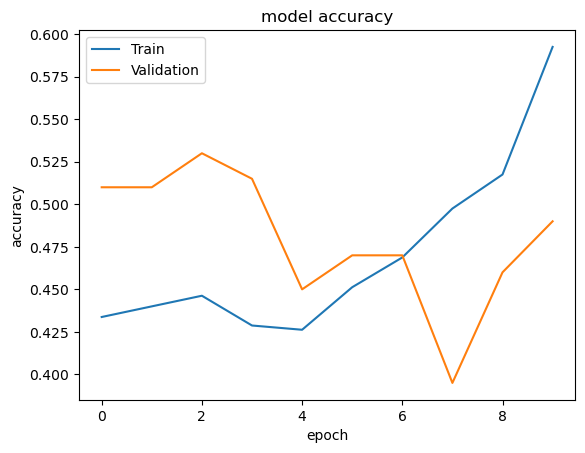

In [31]:
plt.plot(train_history.history['balanced_accuracy'])
plt.plot(train_history.history['val_balanced_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
df_ratings = ratings_.head(1000)

In [56]:
df_features = df_ratings.pivot_table(
    index = "user_id",
    columns = "business_id",
    values = "labels",
).fillna(0)

In [57]:
from scipy.sparse.linalg import svds

In [61]:
U, sigma, Vt = svds(df_features, k =6)

In [66]:
U[0]

array([ 1.33152321e-19,  1.73768703e-19, -5.29600903e-19, -4.39392725e-18,
       -1.23245268e-18, -5.17206498e-20])